In [1]:
# https://www.kaggle.com/datasets/kukuroo3/body-performance-data

In [242]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from fastprogress import progress_bar

In [235]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [141]:
# set defult figuare settings
sns.set_theme(
    style='darkgrid',
    rc={"figure.figsize":(16, 9)}
)

palette = {'A':'#159090', 'B':'#3484f0', 'C':'#f0a034', 'D':'#A034F0'}

In [147]:
# loading dataset
df = pd.read_csv('data/bodyPerformance.csv')
df.head()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


### Feature Engineering

In [148]:
# drop na values
df.dropna(inplace=True)

# reset index
df.reset_index(inplace=True, drop=True)

# one-hot encoding
df = pd.get_dummies(df, columns=['gender'], drop_first=True)
df['gender_M'] = df['gender_M'].astype(np.int8)

### Normalize

In [150]:
# scaling the data
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df.drop(['gender_M', 'class'], axis=1)),
                        columns=df.columns[:-2])

df_scaled[['gender_M', 'class']] = df[['gender_M', 'class']]

In [151]:
from itertools import combinations
def find_best_cols_for_pca(x, thld, r):
    best_comb = []
    
    for c in combinations(x.columns, r):
        c = list(c) # convert to list
        pca = PCA()
        pca.fit_transform(x[c])
        if (np.cumsum(pca.explained_variance_ratio_) * 100)[r-2] >= thld:
            best_comb.append(c)
            
    return best_comb

In [254]:
# best_comb_2 = find_best_cols_for_pca(df_scaled.drop('class', axis=1), 90, 2)
# best_comb_2

In [255]:
# best_comb_3 = find_best_cols_for_pca(df_scaled.drop('class', axis=1), 90, 3)
# best_comb_3

### Selected Columns

In [154]:
# sel_columns = ['sit and bend forward_cm', 'sit-ups counts' , 'broad jump_cm']
sel_columns = ['body fat_%', 'gripForce', 'broad jump_cm']

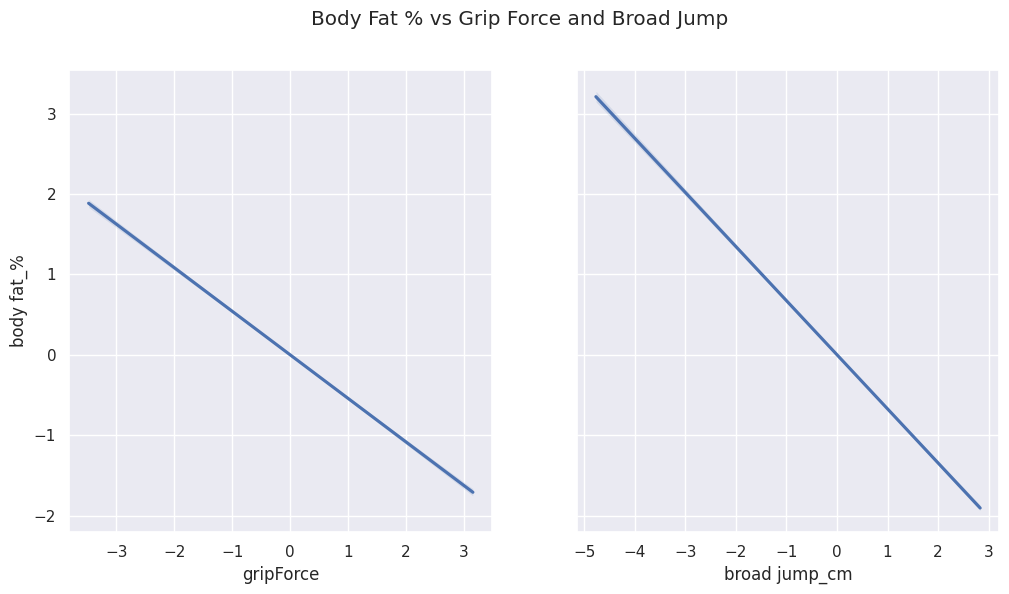

In [270]:
fig, ax =plt.subplots(1,2, sharey=True, figsize=(12,6))

sns.regplot(x='gripForce', y='body fat_%', data=df_scaled, scatter=False, ax=ax[0])
sns.regplot(x='broad jump_cm', y='body fat_%', data=df_scaled, scatter=False, ax=ax[1])

ax[1].set_ylabel('') # remove label
fig.suptitle('Body Fat % vs Grip Force and Broad Jump')
plt.show()

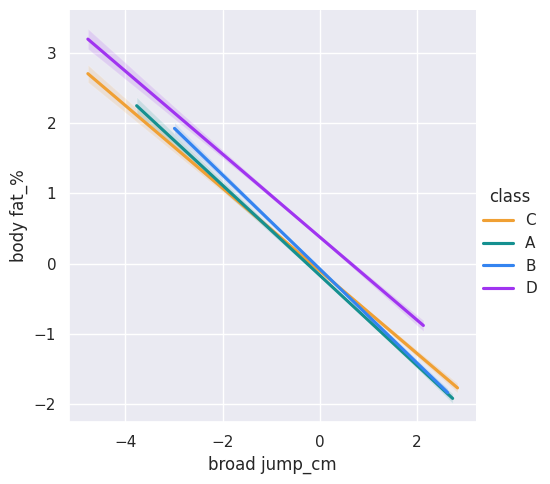

In [261]:
sns.lmplot(x='broad jump_cm', y='body fat_%', hue='class', data=df_scaled, scatter=False, palette=palette)

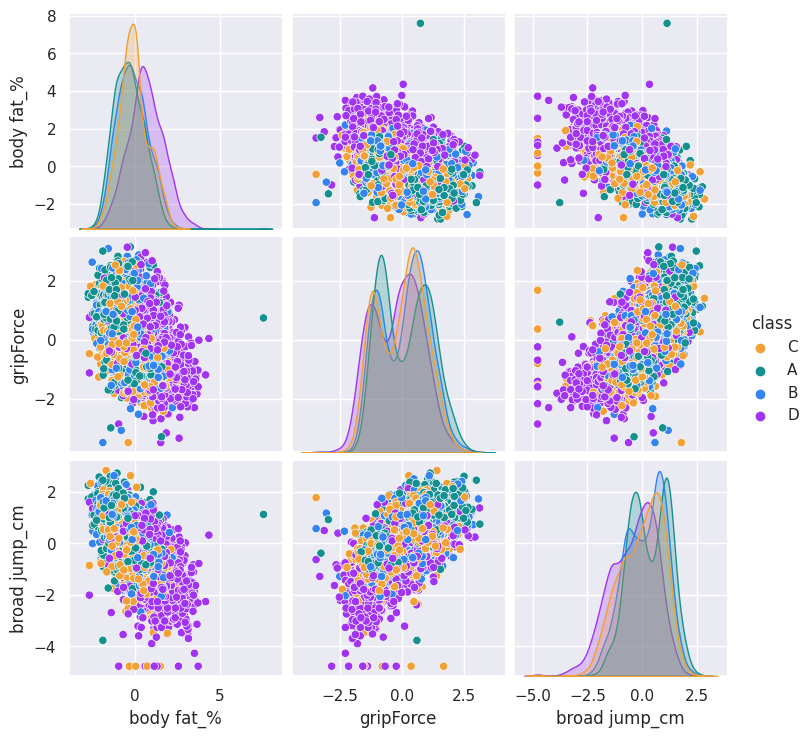

In [155]:
sns.pairplot(df_scaled[sel_columns + ['class']], hue='class',
             palette=palette)

In [156]:
# selecting columns
x_selected = df_scaled[sel_columns].copy()

# applying pca
pca = PCA()
x_selected = pd.DataFrame(pca.fit_transform(x_selected),
                          columns=[f'PC{i}' for i in range(1, x_selected.shape[1]+1)])

In [157]:
pca.explained_variance_ratio_

array([0.7705043 , 0.15498533, 0.07451038])

In [158]:
pca.components_

array([[ 0.54904757, -0.57319721, -0.60826945],
       [ 0.78041709,  0.61209379,  0.12763366],
       [-0.2991587 ,  0.54478083, -0.78340151]])

In [159]:
np.square(pca.components_[:, 1]).sum()

0.9999999999999994

In [160]:
pca_loadings = pca.components_.T * (np.sqrt(pca.explained_variance_))
pca_loadings = pd.DataFrame(pca_loadings, columns=x_selected.columns, index=sel_columns)

pca_loadings

,PC1,PC2,PC3
body fat_%,0.834784,0.532168,-0.141445
gripForce,-0.871502,0.417388,0.257577
broad jump_cm,-0.924827,0.087034,-0.370399


In [161]:
np.allclose(np.square(pca_loadings['PC1']).sum(), x_selected['PC1'].var())

True

### All Data

In [162]:
# split variable and targets
x = df_scaled.drop(['class'], axis=1)
y = df_scaled['class']

In [163]:
x

,age,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,gender_M
0,-0.717432,0.443873,0.652150,-0.267367,0.112009,-0.015959,1.688190,0.377317,1.416961,0.674009,1
1,-0.864220,-0.422465,-0.974734,-1.039081,-0.167278,-0.287820,-0.053073,0.128984,0.926634,0.975013,1
2,-0.423857,1.310211,0.883127,-0.432734,1.229158,1.479276,0.737554,-0.379509,0.646446,-0.229005,1
3,-0.350463,0.704961,0.305684,-0.667004,-0.260374,1.139450,0.417538,-0.001096,0.926634,0.724176,1
4,-0.644038,0.621888,0.021147,-0.846152,-0.818948,-0.219855,0.615195,1.406129,0.366259,0.674009,1
...,...,...,...,...,...,...,...,...,...,...,...
13388,-0.864220,0.420138,0.364265,-0.970178,-0.446565,0.731658,-0.109547,0.259063,0.506353,0.197418,1
13389,-1.157795,1.322079,-0.296866,-1.535183,-0.446565,-0.151890,-0.373090,-1.668480,0.576400,-0.580177,1
13390,0.163293,1.025388,1.092346,-0.432734,-0.074183,0.119971,2.497643,0.140809,0.366259,0.975013,1
13391,1.998138,-2.665451,-0.815728,2.364730,-1.005140,-0.627647,-1.662566,-0.710621,-2.785848,-2.887878,0


In [164]:
# scaling the data
pca = PCA()
x_pca = pd.DataFrame(pca.fit_transform(x),
                     columns=[f'PC{i}' for i in range(1, df.shape[1])])

<Axes: >

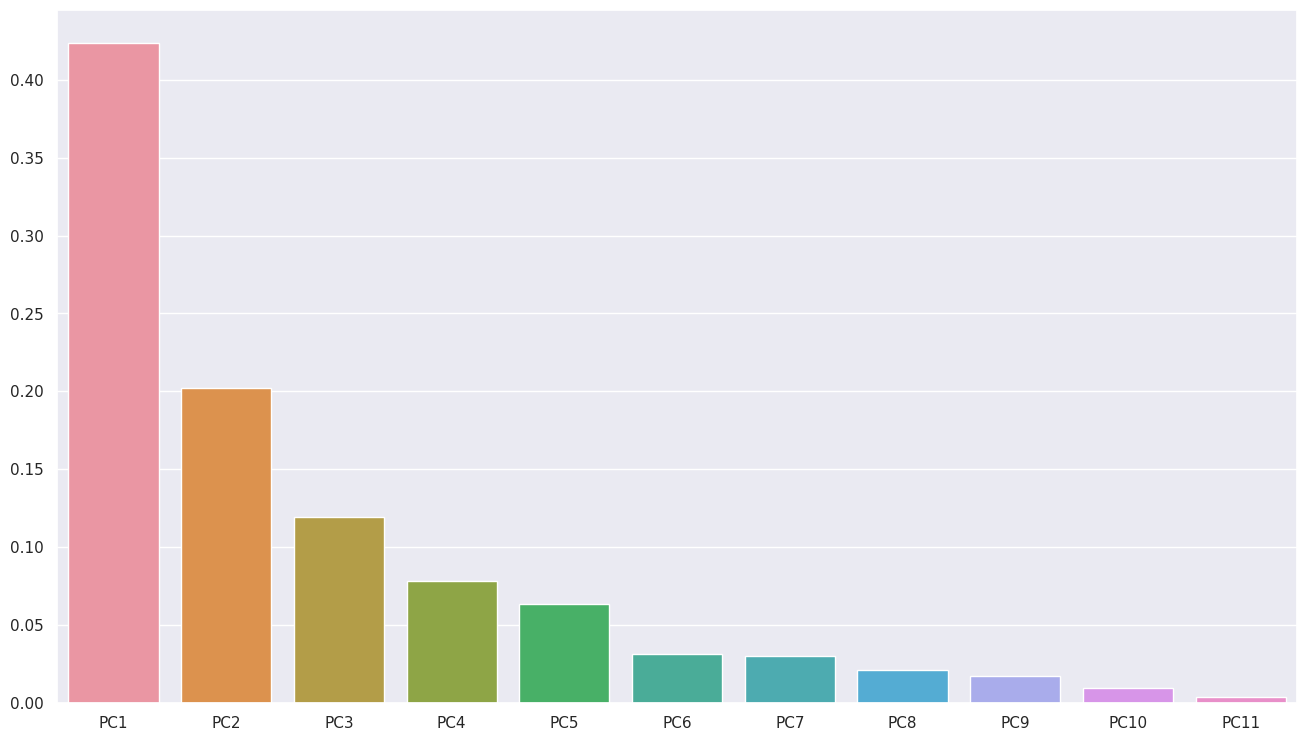

In [165]:
sns.barplot(x=x_pca.columns, y=pca.explained_variance_ratio_)

In [166]:
np.square(pca.components_[:, 1]).sum()

1.0000000000000002

In [167]:
pca_loadings = pca.components_.T * (np.sqrt(pca.explained_variance_))
pca_loadings = pd.DataFrame(pca_loadings, columns=x_pca.columns, index=x.columns)

pca_loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
age,0.406249,-0.558143,0.037912,-0.661776,0.194876,-0.058338,0.132274,0.124899,-0.090907,0.032291,-0.018563
height_cm,-0.863211,-0.093175,-0.246886,-0.015315,0.104817,0.262854,-0.231424,0.160774,-0.048658,0.152383,0.000521
weight_kg,-0.698792,-0.417310,-0.335821,0.173849,0.386726,-0.018747,0.003593,0.048660,-0.019776,-0.202894,-0.027783
body fat_%,0.673459,-0.354522,-0.185089,0.478614,0.310407,-0.133706,0.121315,-0.007604,-0.075750,0.148753,0.025367
diastolic,-0.224323,-0.718058,0.452988,0.218272,-0.204046,0.288034,0.236573,0.021637,0.009886,-0.013065,-0.002033
systolic,-0.302731,-0.736277,0.423821,0.060801,-0.123695,-0.266993,-0.308922,-0.027862,0.002699,0.013853,-0.003066
gripForce,-0.889371,-0.121334,-0.056016,-0.154334,0.176293,-0.070096,0.141440,-0.187751,0.256514,0.099891,-0.019746
sit and bend forward_cm,0.110171,0.401565,0.739331,-0.001842,0.512466,0.102299,-0.076777,-0.020223,0.003334,-0.012721,0.022495
sit-ups counts,-0.762481,0.398895,0.243516,0.124504,-0.067764,-0.235280,0.177149,0.304205,0.019641,0.022744,-0.002190
broad jump_cm,-0.894117,0.203842,0.097301,-0.037331,-0.034328,-0.055220,0.100268,-0.202700,-0.301915,0.029543,-0.028661


In [168]:
np.allclose(np.square(pca_loadings['PC1']).sum(), x_pca['PC1'].var())

True

In [169]:
np.cumsum(pca.explained_variance_ratio_)

array([0.42373621, 0.62567381, 0.74484891, 0.82334592, 0.8870216 ,
       0.9182201 , 0.9481017 , 0.96910977, 0.98617319, 0.99597627,
       1.        ])

In [181]:
num_components = np.min(np.where((np.cumsum(pca.explained_variance_ratio_) * 100) >= 90)) + 1
num_components

6

### Split into train and test

In [231]:
from sklearn.model_selection import train_test_split

# split sclaed data
x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True, test_size=0.20)

# 
y_train = y_train.map({'A':0, 'B':1, 'C':2, 'D':3})
y_test = y_test.map({'A':0, 'B':1, 'C':2, 'D':3})

# get the same split for pca data
x_pca_train = x_pca.loc[x_train.index]
x_pca_test = x_pca.loc[x_test.index]

# assert all indecies for x and x_pca
assert np.all(x_train.index == x_pca_train.index)
assert np.all(x_test.index == x_pca_test.index)

### MLP Classifier

In [230]:
from sklearn.neural_network import MLPClassifier

def fit_tree_cls(x, y, x_test, y_test):
    cls = MLPClassifier(hidden_layer_sizes=[30, 30, 30],
                        batch_size=100,
                        shuffle=True,
                        max_iter=100)
    cls.fit(x, y)
    return cls.score(x_test, y_test)

In [232]:
# select only the components till 90% explained variance
x_pca_train_comp = x_pca_train.iloc[:, :num_components]
x_pca_test_comp = x_pca_test.iloc[:, :num_components]

In [243]:
# collect results
scores = {'all':[], 'pca':[]}

# run the model for 10 times
for i in progress_bar(range(10)):
    
    scores['all'].append(fit_tree_cls(x_train, y_train, x_test, y_test))
    scores['pca'].append(fit_tree_cls(x_pca_train, y_train, x_pca_test, y_test))

In [253]:
f"The Accuracy of all data vs only {num_components} components of PCA is: ~{(np.mean(scores['all']) - np.mean(scores['pca']))*100:.2f}%"

'The Accuracy of all data vs only 6 components of PCA is: ~0.18%'

In [ ]:
import numpy as np
 
def PCA(X , num_components):
     
    #Step-1
    X_meaned = X - np.mean(X , axis = 0)
     
    #Step-2
    cov_mat = np.cov(X_meaned , rowvar = False)
     
    #Step-3
    eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)
     
    #Step-4
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]
     
    #Step-5
    eigenvector_subset = sorted_eigenvectors[:,0:num_components]
     
    #Step-6
    X_reduced = np.dot(eigenvector_subset.transpose() , X_meaned.transpose() ).transpose()
     
    return X_reduced